In [1]:
import sys, os

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sn

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
try:
    data = pd.read_csv('../dataset/clean_bo3.csv', encoding='utf-8-sig', converters={'p_start':eval,'p_temp':eval,'p_end':eval}, index_col=0)
except:
    sys.path.append(os.path.realpath('../'))
    data = pd.read_csv('../dataset/clean_bo3.csv', encoding='utf-8-sig', converters={'p_start':eval,'p_temp':eval,'p_end':eval}, index_col=0)

data = data.drop(columns=['pre_routes','freq'])
data.reset_index(level=0, inplace=True)
print(type(data['p_start'][0]))

data.head(10)

<class 'tuple'>


,index,vehicle_id,p_start,p_temp,p_end,label
0,0,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.738, 10.8012)",False
1,16,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.73100000000001, 10.7996)",False
2,21,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.721, 10.7981)",False
3,40,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.695, 10.7912)",False
4,50,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.68799999999999, 10.7858)",False
5,59,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.681, 10.7926)",False
6,102,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.736, 10.8026)",False
7,106,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.734, 10.8034)",False
8,107,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.73200000000001, 10.8028)",False
9,112,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.73200000000001, 10.8)",False


In [3]:
data[['p_start','p_temp', 'p_end', 'label']]

,p_start,p_temp,p_end,label
0,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.738, 10.8012)",False
1,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.73100000000001, 10.7996)",False
2,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.721, 10.7981)",False
3,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.695, 10.7912)",False
4,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.68799999999999, 10.7858)",False
...,...,...,...,...
14856,"(106.682, 10.822000000000001)","(106.679, 10.8284)","(106.677, 10.8429)",True
14857,"(106.682, 10.8224)","(106.68, 10.8272)","(106.679, 10.8515)",True
14858,"(106.682, 10.8237)","(106.679, 10.8284)","(106.677, 10.8429)",True
14859,"(106.68, 10.8272)","(106.677, 10.8429)","(106.677, 10.8432)",True


In [4]:
# data['pre_routes'] = data['pre_routes'].apply(lambda x: list(x))
data['label'] = data['label'].apply(lambda label: -1 if label == False else 1)
# data = data.sample(frac=0.4)

print("N_normal: ",len(data[data['label']==-1]))
print("N_abnormal: ",len(data[data['label']==1]))
data['label'].describe()

N_normal:  9401
N_abnormal:  5460


count    14861.000000
mean        -0.265191
std          0.964228
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [5]:
data['feature'] = data['p_start'] + data['p_temp'] + data['p_end']
data

,index,vehicle_id,p_start,p_temp,p_end,label,feature
0,0,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.738, 10.8012)",-1,"(106.74, 10.8014, 106.73899999999999, 10.8012,..."
1,16,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.73100000000001, 10.7996)",-1,"(106.74, 10.8014, 106.73899999999999, 10.8012,..."
2,21,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.721, 10.7981)",-1,"(106.74, 10.8014, 106.73899999999999, 10.8012,..."
3,40,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.695, 10.7912)",-1,"(106.74, 10.8014, 106.73899999999999, 10.8012,..."
4,50,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.68799999999999, 10.7858)",-1,"(106.74, 10.8014, 106.73899999999999, 10.8012,..."
...,...,...,...,...,...,...,...
14856,7272177,100000533,"(106.682, 10.822000000000001)","(106.679, 10.8284)","(106.677, 10.8429)",1,"(106.682, 10.822000000000001, 106.679, 10.8284..."
14857,7272544,100000533,"(106.682, 10.8224)","(106.68, 10.8272)","(106.679, 10.8515)",1,"(106.682, 10.8224, 106.68, 10.8272, 106.679, 1..."
14858,7272961,100000533,"(106.682, 10.8237)","(106.679, 10.8284)","(106.677, 10.8429)",1,"(106.682, 10.8237, 106.679, 10.8284, 106.677, ..."
14859,7274155,100000533,"(106.68, 10.8272)","(106.677, 10.8429)","(106.677, 10.8432)",1,"(106.68, 10.8272, 106.677, 10.8429, 106.677, 1..."


In [6]:
X = data['feature']
y = data['label']

In [7]:
# dataframe = pd.DataFrame(X_train_vec.A, columns=vectorizer.get_feature_names())
# dataframe

In [8]:
def clf_report(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=['Normal','Anomaly']))

    cm = confusion_matrix(y_true,y_pred, labels=[-1,1])    
    df_cm = pd.DataFrame(cm,columns = ['Normal','Anomaly'])
    df_cm = df_cm.rename(index = {0:'Normal',1:'Anomaly'})
    sn.heatmap(df_cm, annot=True, fmt="d")
    plt.show()

    return precision_recall_fscore_support(y_true,y_pred,average='macro')

In [9]:
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# X_train_mat = vectorizer.fit_transform(X_train[30:35])
# dataframe = pd.DataFrame(X_train_mat.A, columns=[vectorizer.get_feature_names()])[:30]
# # dataframe['X'] = X_train[30:35].tolist()

# dataframe.index = X_train[30:35].to_numpy()
# dataframe
# # X_train_mat

==================================================1==================================================

Evaluation for training
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7520
     Anomaly       1.00      1.00      1.00      4368

    accuracy                           1.00     11888
   macro avg       1.00      1.00      1.00     11888
weighted avg       1.00      1.00      1.00     11888



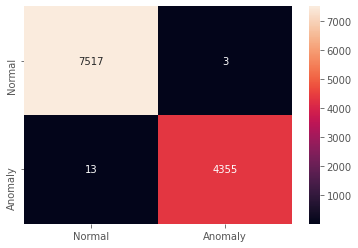

Evaluation for testing
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      1881
     Anomaly       0.98      0.97      0.97      1092

    accuracy                           0.98      2973
   macro avg       0.98      0.98      0.98      2973
weighted avg       0.98      0.98      0.98      2973



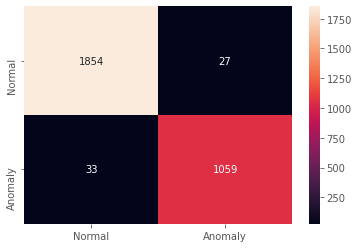


==================================================2==================================================

Evaluation for training
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7521
     Anomaly       1.00      1.00      1.00      4368

    accuracy                           1.00     11889
   macro avg       1.00      1.00      1.00     11889
weighted avg       1.00      1.00      1.00     11889



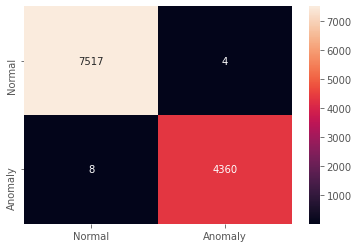

Evaluation for testing
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      1880
     Anomaly       0.97      0.96      0.97      1092

    accuracy                           0.98      2972
   macro avg       0.98      0.97      0.98      2972
weighted avg       0.98      0.98      0.98      2972



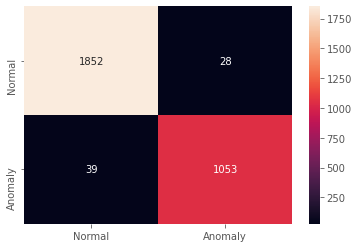


==================================================3==================================================

Evaluation for training
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7521
     Anomaly       1.00      1.00      1.00      4368

    accuracy                           1.00     11889
   macro avg       1.00      1.00      1.00     11889
weighted avg       1.00      1.00      1.00     11889



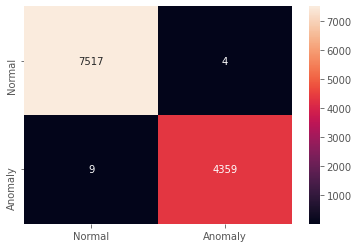

Evaluation for testing
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      1880
     Anomaly       0.97      0.96      0.97      1092

    accuracy                           0.98      2972
   macro avg       0.97      0.97      0.97      2972
weighted avg       0.98      0.98      0.98      2972



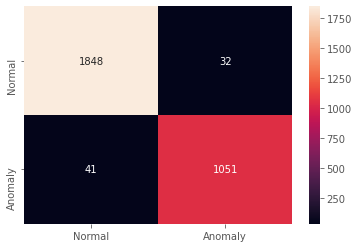


==================================================4==================================================

Evaluation for training
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7521
     Anomaly       1.00      1.00      1.00      4368

    accuracy                           1.00     11889
   macro avg       1.00      1.00      1.00     11889
weighted avg       1.00      1.00      1.00     11889



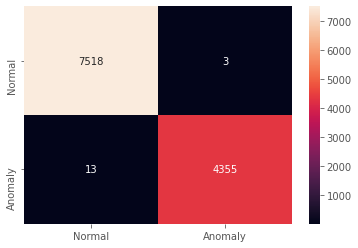

Evaluation for testing
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      1880
     Anomaly       0.97      0.96      0.97      1092

    accuracy                           0.97      2972
   macro avg       0.97      0.97      0.97      2972
weighted avg       0.97      0.97      0.97      2972



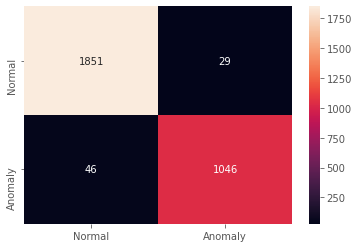


==================================================5==================================================

Evaluation for training
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7521
     Anomaly       1.00      1.00      1.00      4368

    accuracy                           1.00     11889
   macro avg       1.00      1.00      1.00     11889
weighted avg       1.00      1.00      1.00     11889



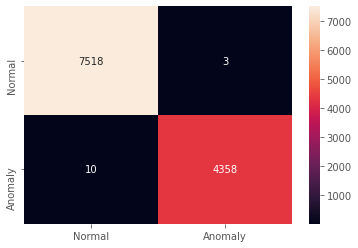

Evaluation for testing
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98      1880
     Anomaly       0.97      0.95      0.96      1092

    accuracy                           0.97      2972
   macro avg       0.97      0.97      0.97      2972
weighted avg       0.97      0.97      0.97      2972



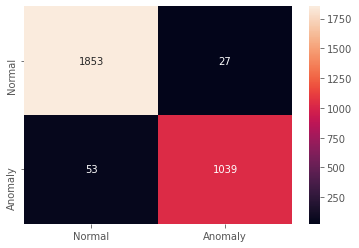

,precision,recall,f1-score,accuracy
training,0.998906,0.998561,0.998733,0.998822
test,0.975551,0.972980,0.974233,0.976112


In [11]:
clf = SVC(C=5.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42)

i = 1

precision_train = []
recall_train = []
f1_train = []
acc_train = []

precision_test = []
recall_test = []
f1_test = []
acc_test = []


for train_index, test_index in cv.split(X, y):
    
    print("="*50 + str(i) + "="*50)
    print()

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_mat = vectorizer.fit_transform(X_train)
    X_test_mat = vectorizer.transform(X_test)
    
    clf.fit(X_train_mat,y_train)
#     clf.fit(X_train_mat)
    y_train_pred = clf.predict(X_train_mat)
    y_test_pred = clf.predict(X_test_mat)


    print("Evaluation for training")
    precision,recall,fscore,support = clf_report(y_train,y_train_pred)
    precision_train.append(precision)
    recall_train.append(recall)
    f1_train.append(fscore)
    acc_train.append(accuracy_score(y_train,y_train_pred))


    print("Evaluation for testing")
    precision,recall,fscore,support = clf_report(y_test,y_test_pred)
    precision_test.append(precision)
    recall_test.append(recall)
    f1_test.append(fscore)
    acc_test.append(accuracy_score(y_test,y_test_pred))    
    
    i+=1
    print()
    
mean_precision_train = np.mean(precision_train)
mean_recall_train = np.mean(recall_train)
mean_f1_train = np.mean(f1_train)
mean_acc_train = np.mean(acc_train)

mean_precision_test = np.mean(precision_test)
mean_recall_test = np.mean(recall_test)
mean_f1_test = np.mean(f1_test)
mean_acc_test = np.mean(acc_test)

train_perfm = [mean_precision_train, mean_recall_train, mean_f1_train, mean_acc_train]
test_perfm = [mean_precision_test, mean_recall_test, mean_f1_test, mean_acc_test]

performance = pd.DataFrame([train_perfm, test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['training','test'])
performance

# Evaluation

In [12]:
y_test_pred, test_index

(array([-1, -1, -1, ...,  1,  1,  1], dtype=int64),
 array([   10,    22,    24, ..., 14842, 14849, 14851]))

In [13]:
df = data.copy().drop(columns=['p_start','p_temp', 'p_end','index'])
test = df.iloc[test_index]
test.reset_index(level=0, inplace=True)
test

,index,vehicle_id,label,feature
0,10,100000025,-1,"(106.74, 10.8014, 106.738, 10.8012, 106.731000..."
1,22,100000025,-1,"(106.74, 10.8014, 106.73200000000001, 10.8028,..."
2,24,100000025,-1,"(106.74, 10.8014, 106.73200000000001, 10.8028,..."
3,33,100000025,-1,"(106.74, 10.8014, 106.73100000000001, 10.7996,..."
4,53,100000025,-1,"(106.74, 10.8014, 106.695, 10.7912, 106.682, 1..."
...,...,...,...,...
2967,14833,100000533,1,"(106.67399999999999, 10.8083, 106.679, 10.8136..."
2968,14841,100000533,1,"(106.67399999999999, 10.8091, 106.681, 10.8169..."
2969,14842,100000533,1,"(106.67399999999999, 10.8091, 106.679, 10.8284..."
2970,14849,100000533,1,"(106.681, 10.8169, 106.681, 10.817, 106.68, 10..."


In [14]:
test['pred'] = y_test_pred
test

<ipython-input-14-0172d455b860>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = y_test_pred


,index,vehicle_id,label,feature,pred
0,10,100000025,-1,"(106.74, 10.8014, 106.738, 10.8012, 106.731000...",-1
1,22,100000025,-1,"(106.74, 10.8014, 106.73200000000001, 10.8028,...",-1
2,24,100000025,-1,"(106.74, 10.8014, 106.73200000000001, 10.8028,...",-1
3,33,100000025,-1,"(106.74, 10.8014, 106.73100000000001, 10.7996,...",-1
4,53,100000025,-1,"(106.74, 10.8014, 106.695, 10.7912, 106.682, 1...",-1
...,...,...,...,...,...
2967,14833,100000533,1,"(106.67399999999999, 10.8083, 106.679, 10.8136...",1
2968,14841,100000533,1,"(106.67399999999999, 10.8091, 106.681, 10.8169...",1
2969,14842,100000533,1,"(106.67399999999999, 10.8091, 106.679, 10.8284...",1
2970,14849,100000533,1,"(106.681, 10.8169, 106.681, 10.817, 106.68, 10...",1


In [17]:
import folium

def visualize(longitude, latitude):

    m = folium.Map(location=(np.median(latitude), np.median(longitude)), tiles='OpenStreetMap', zoom_start=15)

    folium.PolyLine(list(zip(latitude, longitude)), color="red", weight=5.0, opacity=1).add_to(m)

    folium.Marker((latitude[0], longitude[0]), popup="Start", icon=folium.Icon(color='green')).add_to(m)
    folium.Marker((latitude[-1], longitude[-1]), popup="End", icon=folium.Icon(color='red')).add_to(m)

    return m
    
def preprocess(coords):
    lon, lat = [], []
    for idx, item in enumerate(coords):
        if idx % 2 == 0:
            lon.append(item)
        else:
            lat.append(item)
    return lon,lat




In [18]:
abnormal_df = test[test['pred']==1]
abnormal_df

,index,vehicle_id,label,feature,pred
59,245,100000025,-1,"(106.73200000000001, 10.8, 106.68299999999999,...",1
160,723,100000099,-1,"(106.72399999999999, 10.8312, 106.705, 10.821,...",1
161,726,100000099,-1,"(106.72399999999999, 10.8312, 106.705, 10.821,...",1
401,1997,100000299,-1,"(106.65799999999999, 10.7378, 106.661, 10.747,...",1
455,2262,100000299,-1,"(106.66, 10.7491, 106.669, 10.7598, 106.667, 1...",1
...,...,...,...,...,...
2967,14833,100000533,1,"(106.67399999999999, 10.8083, 106.679, 10.8136...",1
2968,14841,100000533,1,"(106.67399999999999, 10.8091, 106.681, 10.8169...",1
2969,14842,100000533,1,"(106.67399999999999, 10.8091, 106.679, 10.8284...",1
2970,14849,100000533,1,"(106.681, 10.8169, 106.681, 10.817, 106.68, 10...",1


In [20]:
coords = abnormal_df.sample()['feature'].tolist()[0]
lon, lat = preprocess(coords)
visualize(lon,lat)